In [1]:
import os
import pandas as pd 
import numpy as np
from scipy.optimize import curve_fit
from scipy import integrate 
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
%pylab inline


Populating the interactive namespace from numpy and matplotlib


#proyecto final-Herramientas computacionales#

Para este proyecto se buscó poder estimar el peso, las velocidades de operación y las dimensiones de un motor de paletas diseñado para un caudal dado a partir de la metodología de líneas de willan y los datos obtenidos de la caracterización de un modelo a escala de este.

<img src="il1.png">



In [2]:
##Se cargan los datos experimentales  
nom_torque= 'torques'
nom_caudal_med= 'caudales'
nom_presion= 'presiones2'
nom_temperatura= 'temperaturas'

dir_torque = os.path.join(nom_torque+'.csv')
dir_caudal= os.path.join(nom_caudal_med+'.csv')
dir_temp = os.path.join(nom_temperatura+'.csv')
dir_presion = os.path.join(nom_presion+'.csv')
torques= pd.read_csv(dir_torque, sep = ';',encoding='latin-1')
caudales_med= pd.read_csv(dir_caudal, sep = ';',encoding='latin-1')
presiones= pd.read_csv(dir_presion, sep = ';',encoding='latin-1')
temperaturas= pd.read_csv(dir_temp, sep = ';',encoding='latin-1')

##se define la geometria del motor base
r1=17#radio rotor
r2=18.7#radio estator
w=22#grosor del estator
h=1.5#ancho paletas
N=4#numero de paletas
peso=1.37#peso del motor
vol_actual=(r1**2)*np.pi*w#volumen del rotor

##se determina la velocidad angular en RPM y se encuentra la velocidad caracteristica
columnas=presiones.columns.tolist()
omegas=np.asarray([float(i) for i in columnas])
omegaesp=omegas*((r2+r1)/2000)
omegas2=np.asarray([666,1000,2000,3000,4000,5000,6000,7000,8000])
omegaesp2=omegas2*((r2+r1)/2000)

##se determina el factor de correccion de los caudales a partir de las temperaturas y presiones registradas
factor_correcion=np.sqrt(((presiones+14.7)/14.7)*(273.15/(temperaturas+273.15)))
caudales=caudales_med*factor_correcion

<img src="graf_il2.png">

In [4]:
##se generan las funciones con las que se determina el volumen de trabajo
def rv(x,R1,R2):
 d=(R2-R1)   
 val1=d*np.cos(x)
 val2=np.sqrt((R1**2)+((d*np.sin(x))**2))
 return val1+val2

def rvint(x,R1,R2):
 return (rv(x,R1,R2))**2
def calc_area(R1,R2):
 return integrate.quad(rvint, (np.pi/-4), (np.pi/4), args=(R1,R2))


#se determina el volumen de trabajo
area = calc_area(r1,r2)#area transversal del volumen de trabajo
volpalet=2*w*h*(rv((np.pi/4),r1,r2)-r1)#volumen de las paletas
vol=((w*(area[0]-(r1*r1*np.pi/N)))-volpalet)/1000#volumen del area de trabajo [mm^3]

#se determinan los valores de pma y pme a partir de los caudales las presiones y los torques registrados
energia=60*48.8*np.log((presiones+14.7)/14.7)
omegarev=1/omegas
pma=torques*2*np.pi/vol
pme=caudales*energia/vol
pme=pme.multiply(omegarev, axis=1)

In [5]:
#se definen las funciones con las que se realizara el analisis del comportamiento de los parametros deseados
def log(x, a, b):
 return a * np.log(x) + b
def poli1(x, a, b):
 return ((a*x)+b)
def poli2(x, a, b, c):
 return ((a*x)+(b*x**2)+c)
def poli3(x, a, b, c, d):
 return ((a*x)+(b*x**2)+(c*x**3)+d)
def exp(x, a, b):
 return a * (x**b)

funciones=['poli1','poli2','exp','poli3']

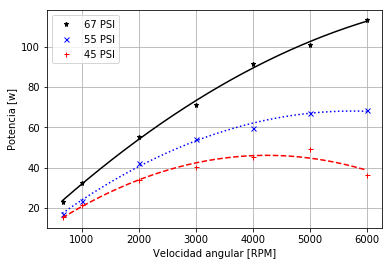

In [6]:
velangs=np.linspace(660,6000,1000)
plt.plot(omegas,(torques.iloc[1]*omegas*0.104719755),'*',c='k',markersize=5,label='67 PSI')
popt, pcov = curve_fit(poli2,omegas,torques.iloc[1]*omegas*0.104719755)
plt.plot(velangs,poli2(velangs, *popt),c='k')
plt.plot(omegas,(torques.iloc[2]*omegas*0.104719755),'x',c='b',markersize=5,label='55 PSI')
popt, pcov = curve_fit(poli2,omegas,torques.iloc[2]*omegas*0.104719755)
plt.plot(velangs,poli2(velangs, *popt),c='b',ls=':')
plt.plot(omegas,(torques.iloc[3]*omegas*0.104719755),'+',c='r',markersize=5,label='45 PSI')
popt, pcov = curve_fit(poli2,omegas,torques.iloc[3]*omegas*0.104719755)
plt.plot(velangs,poli2(velangs, *popt),c='r',ls='--')
plt.grid()
plt.xlabel("Velocidad angular [RPM]")
plt.ylabel("Potencia [w]")
plt.legend()
pylab.savefig(os.path.join('graf0.png'), dpi=600)



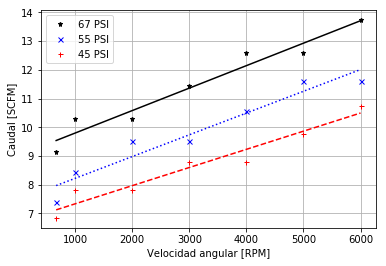

In [7]:
velangs=np.linspace(666,6000,1000)
plt.plot(omegas,(caudales.iloc[1]),'*',c='k',markersize=5,label='67 PSI')
popt, pcov = curve_fit(poli1,omegas,caudales.iloc[1])
plt.plot(velangs,poli1(velangs, *popt),c='k')
plt.plot(omegas,(caudales.iloc[2]),'x',c='b',markersize=5,label='55 PSI')
popt, pcov = curve_fit(poli1,omegas,caudales.iloc[2])
plt.plot(velangs,poli1(velangs, *popt),c='b',ls=':')
plt.plot(omegas,(caudales.iloc[3]),'+',c='r',markersize=5,label='45 PSI')
popt, pcov = curve_fit(poli1,omegas,caudales.iloc[3])
plt.plot(velangs,poli1(velangs, *popt),c='r',ls='--')
plt.grid()
plt.xlabel("Velocidad angular [RPM]")
plt.ylabel("Caudal [SCFM]")
plt.legend()
pylab.savefig(os.path.join('graf1.png'), dpi=600)

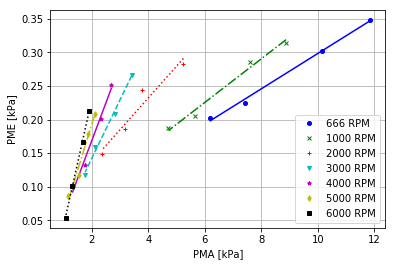

In [8]:
#se determinan las lineas de willan para cada velocidad de rotacion de los datos experimentales
rcuad=[]
e=[]
corte=[]
marc=['o','x','+','v','*','d','s']
lin=['-','-.',':','--','-','-.',':']
col=['b', 'g', 'r', 'c', 'm', 'y', 'k']

for i,k,n,t in zip(columnas,marc,lin,col):
 res= stats.linregress(pme[i],pma[i])
 plt.plot(pme[i], pma[i], marker=k,ls='',c=t, markersize=4,label=i+' RPM')
 plt.plot(pme[i], (res[0]*pme[i] + res[1]),ls=n,c=t,label='')
 e.append(res[0]) 
 corte.append(res[1]) 
 rcuad.append(res[2]) 

plt.xlabel("PMA [kPa]")
plt.ylabel("PME [kPa]")
plt.grid()
plt.legend()
pylab.savefig(os.path.join('graf2.png'), dpi=600)


In [9]:
#se define la funcion para medir el error cuadratico 
def error_cuad(yreal,yteo):
  error=yreal-yteo
  error=error**2
  resultado=np.sum(error)
  return resultado
    

In [10]:
#se define la funcion que calcula el error cuadratico como medida de la sensibilidad del ajuste
def error_sens(funcion,variabley,poptactual,direc,tit_eje):
 noms=[]
 lin=['-','-.',':','--','-','-.',':']
 col=['b', 'g', 'r', 'c', 'm', 'y', 'k']
 long=[0,1,2,3,4,5,6]
 nom=['1','2','3','4','5','6','7']
 error=[0,0,0,0,0,0,0]
 for i,k,n,l in zip(long,col,nom,lin):
  actual=[]  
  actual2=[] 
  for j in long:
    if i==j:
      j
    else:
      actual.append(omegaesp[j])
      actual2.append(variabley[j])    
  popt, pcov = curve_fit(globals()[funcion],actual,actual2) 
  #plt.plot(omegaesp, globals()[funcion](omegaesp, *popt),ls=l,c=k,label='sin punto'+n)
  error_actual=((globals()[funcion](omegaesp, *popt))-(globals()[funcion](omegaesp, *poptactual)))**2
  for k,l in zip(error_actual,long):
    if k>error[l]:
     error[l]=k
 #plt.legend()
 #plt.grid()
 #plt.ylabel(tit_eje)
 #plt.xlabel("Velocidad característica [m/s]")
 #pylab.savefig(os.path.join(direc), dpi=600)
 #plt.close()
 return sum(error)

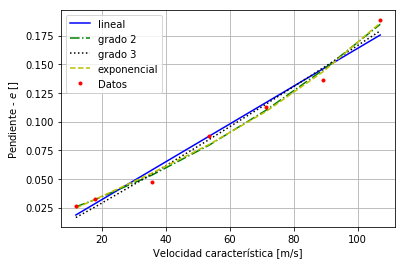

In [11]:
#se determina la curva que mejor se ajusta al comportamiento de la pendiente respecto a la velocidad caracteristica
lin=['-','-.',':','--']
col=['b', 'g', 'k', 'y']
nom=['lineal','grado 2','grado 3','exponencial']
error=10000000000000000000000000000000000
funfin=[]
poptfin=[]


for i,l,k,n in zip(funciones,lin,col,nom):
 popt, pcov = curve_fit(globals()[i],omegaesp,e) 
 eteo=globals()[i](omegaesp, *popt)
 error_actual=error_cuad(e,eteo)
 path=('graf_'+i+'e.png')
 eje='Pendiente - $e$ []'
 er_sensibilidad=error_sens(i,e,popt,path,eje)
 error_total=error_actual+er_sensibilidad
 if error_total < error:
    funfin=i
    poptfin=popt
    error=error_total
 plt.plot(omegaesp, globals()[i](omegaesp, *popt),ls=l,c=k,label=n)
plt.plot(omegaesp,e, 'o',c='r',label='Datos', markersize=3)
plt.xlabel("Velocidad característica [m/s]")
plt.ylabel("Pendiente - $e$ []")
plt.grid()
plt.legend()
pylab.savefig(os.path.join('graf3.png'), dpi=600)

<img src="graf_poli1e.png">
<img src="graf_poli2e.png">
<img src="graf_poli3e.png">
<img src="graf_expe.png">

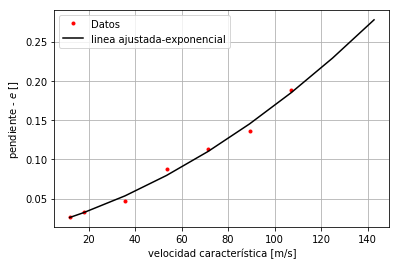

In [12]:
plt.plot(omegaesp,e, 'o',c='r', label='Datos', markersize=3)
plt.plot(omegaesp2, globals()[funfin](omegaesp2, *poptfin),c='k',label='linea ajustada-exponencial')
plt.xlabel("velocidad característica [m/s]")
plt.ylabel("pendiente - $e$ []")
plt.grid()
plt.legend()
pylab.savefig(os.path.join('graf4.png'), dpi=600)


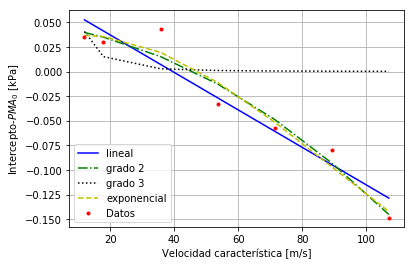

In [13]:
#se determina la curva que mejor se ajusta al comportamiento del intercepto respecto a la velocidad caracteristica
lin=['-','-.',':','--']
col=['b', 'g', 'k', 'y']
nom=['lineal','grado 2','grado 3','exponencial']
error=10000000000000000000000000000000000000000
funfin2=[]
poptfin2=[]

for i,l,k,n in zip(funciones,lin,col,nom):
 popt2, pcov2 = curve_fit(globals()[i],omegaesp,corte) 
 corteo=globals()[i](omegaesp, *popt2)
 error_actual=error_cuad(corte,corteo)
 path=('graf_'+i+'corte.png')
 eje='Intercepto-$PMA_{0}$ [kpa]'
 er_sensibilidad=error_sens(i,corte,popt2,path,eje)
 error_total=error_actual+er_sensibilidad
 if error_total < error:
    funfin2=i
    poptfin2=popt2
    error=error_total
 plt.plot(omegaesp, globals()[i](omegaesp, *popt2),ls=l,c=k,label=n)
plt.plot(omegaesp,corte, 'o',c='r',label='Datos', markersize=3)
plt.xlabel("Velocidad característica [m/s]")
plt.ylabel('Intercepto-$PMA_{0}$ [kPa]')
plt.grid()
plt.legend()
pylab.savefig(os.path.join('graf5.png'), dpi=600)



<img src="graf_poli1corte.png">
<img src="graf_poli2corte.png">
<img src="graf_poli3corte.png">
<img src="graf_expcorte.png">

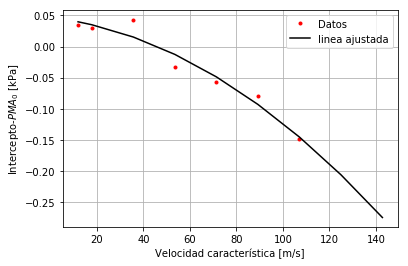

In [14]:
plt.plot(omegaesp,corte, 'o',c='r',label='Datos', markersize=3)
plt.plot(omegaesp2, globals()[funfin2](omegaesp2, *poptfin2),c='k', label='linea ajustada')
plt.xlabel("Velocidad característica [m/s]")
plt.ylabel('Intercepto-$PMA_{0}$ [kPa]')
plt.grid()
plt.legend()
pylab.savefig(os.path.join('graf6.png'), dpi=600)


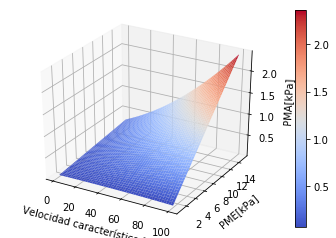

In [15]:
# se calcula el mapa del comportamiento del motor en base a los datos anteriormente encontrados
def calc_pma(omega,pme):
 e=globals()[funfin](omega, *poptfin)
 corte=globals()[funfin2](omega, *poptfin2)
 pma=corte+(e*pme) 
 return pma

omegagraf=np.linspace(100,1,100)
pmegraf=(np.linspace(1,15,100))
omegagraf

X, Y = np.meshgrid(omegagraf, pmegraf)
pmas = np.array([calc_pma(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = pmas.reshape(X.shape)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('Velocidad característica [m/s]')
ax.set_ylabel('PME[kPa]')
ax.set_zlabel('PMA[kPa]')
surf=ax.plot_surface(X, Y, Z,cmap=cm.coolwarm)
fig.colorbar(surf)
pylab.savefig(os.path.join('graf7.png'), dpi=600)

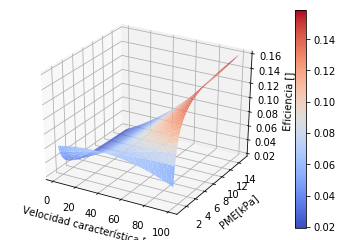

In [16]:
#se determina el mapa de efieciencia del motor 
def calc_eficiencia(omega,pme):
 e=globals()[funfin](omega, *poptfin)
 corte=globals()[funfin2](omega, *poptfin2)
 pma=corte+(e*pme) 
 ef=pma/pme
 return ef

omegagraf=np.linspace(100,1,100)
pmegraf=(np.linspace(1,15,100))
omegagraf

X, Y = np.meshgrid(omegagraf, pmegraf)
eficiencias = np.array([calc_eficiencia(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])

Z = eficiencias.reshape(X.shape)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf=ax.plot_surface(X, Y, Z,cmap=cm.coolwarm)
fig.colorbar(surf)
ax.set_xlabel('Velocidad característica [m/s]')
ax.set_ylabel('PME[kPa]')
ax.set_zlabel('Eficiencia []')
pylab.savefig(os.path.join('graf8.png'), dpi=600)

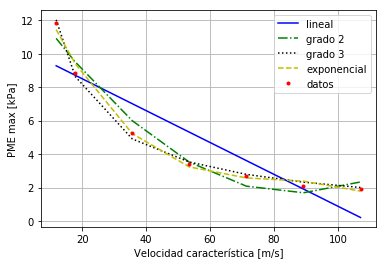

In [17]:
#se calcula el limite de operacion del motor 
pmemax=pme.iloc[0]
lin=['-','-.',':','--']
col=['b', 'g', 'k', 'y']
nom=['lineal','grado 2','grado 3','exponencial']
error=10000000000000000000000000000000000
funfin3=[]
poptfin3=[]
errores=[]


for i,l,k,n in zip(funciones,lin,col,nom):
 popt3, pcov3 = curve_fit(globals()[i],omegaesp,pmemax) 
 teor=globals()[i](omegaesp, *popt3)
 error_actual=error_cuad(pmemax,teor)
 if error_actual < error:
    funfin3=i
    poptfin3=popt3
    error=error_actual
 plt.plot(omegaesp, globals()[i](omegaesp, *popt3),ls=l,c=k,label=n)
plt.plot(omegaesp,pmemax, 'o', label='datos',c='r',markersize=3)
plt.xlabel("Velocidad característica [m/s]")
plt.ylabel("PME max [kPa]")
plt.grid()
plt.legend()
pylab.savefig(os.path.join('graf9.png'), dpi=600)


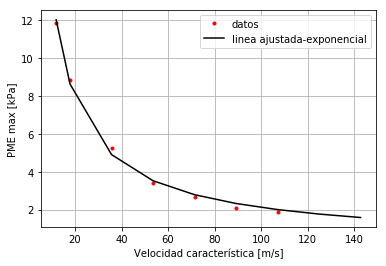

In [18]:
plt.plot(omegaesp,pmemax, 'o', label='datos',c='r',markersize=3)
plt.plot(omegaesp2, globals()[funfin3](omegaesp2, *poptfin3),c='k',label='linea ajustada-exponencial')
plt.xlabel("Velocidad característica [m/s]")
plt.ylabel("PME max [kPa]")
plt.grid()
plt.legend()
pylab.savefig(os.path.join('graf10.png'), dpi=600)


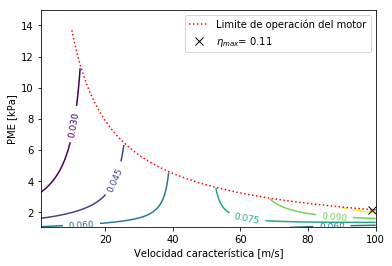

In [19]:
#se calcula la eficiencia maxima dentro de los limites de 
def calc_eficiencia2(omega,pme):
 e=globals()[funfin](omega, *poptfin)
 corte=globals()[funfin2](omega, *poptfin2)
 if pme<(globals()[funfin3](omega, *poptfin3)):
  pma=corte+(e*pme) 
  ef=pma/pme
  if ef>0:
   eficiencia=ef
  else:
   eficiencia=np.nan
 else:
  eficiencia=np.nan
 return eficiencia

omegagraf2=np.linspace(100,10,100)

X, Y = np.meshgrid(omegagraf, pmegraf)
eficiencias = np.array([calc_eficiencia2(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = eficiencias.reshape(X.shape)
maxi= np.nanmax(eficiencias)
local_max_index = np.where(Z==maxi)
fig = plt.figure()
CS=plt.contour(X, Y, Z)
max_omega = X[local_max_index[0], local_max_index[1]]
max_pme = Y[local_max_index[0], local_max_index[1]]
plt.clabel(CS,fontsize=9, inline=1)
plt.plot(omegagraf2, globals()[funfin3](omegagraf2, *poptfin3),c='r',ls=':',label='Limite de operación del motor')
plt.plot(max_omega,max_pme,'x',c='k',label='$\eta_{max}$= '+str(round(maxi, 3)),markersize=8)
plt.legend()
plt.xlabel("Velocidad característica [m/s]")
plt.ylabel("PME [kPa]")
pylab.savefig(os.path.join('graf11.png'), dpi=600)


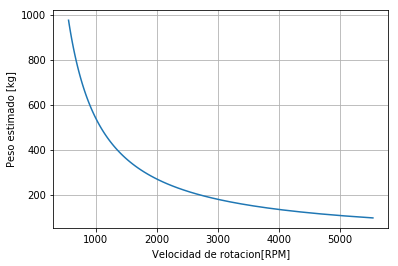

In [20]:
#se determina la relacion entre pesos y velocidad angular del motor esperado
ener=166666*60
r1nuev=np.linspace(r1,10*r1,100)
r2nuev=r1nuev*(r2/r1)
areas_nuevas=[]
for (i,j)in zip(r1nuev,r2nuev):
 resp=calc_area(i,j)
 areas_nuevas.append(resp[0])
areas_nuevas
areanuev=np.array(areas_nuevas)   
    
rpm_nuevo=max_omega*2000/(r1nuev*((r2/r1)+1))
wnuevo=(ener*1000/(rpm_nuevo*max_pme*areanuev))
vol_nuevo=np.pi*wnuevo*(r1nuev**2)

peso_nuevo=peso*vol_nuevo/vol_actual
plot(rpm_nuevo,peso_nuevo)
plt.grid()
plt.xlabel("Velocidad de rotacion[RPM]")
plt.ylabel("Peso estimado [kg]")
pylab.savefig(os.path.join('graf12.png'), dpi=600)

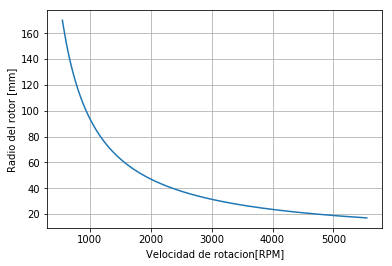

In [21]:
peso_nuevo=peso*vol_nuevo/vol_actual
plot(rpm_nuevo,r1nuev)
plt.grid()
plt.xlabel("Velocidad de rotacion[RPM]")
plt.ylabel("Radio del rotor [mm]")
pylab.savefig(os.path.join('graf13.png'), dpi=600)

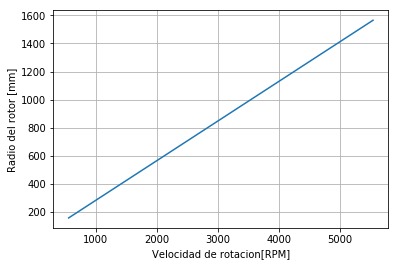

In [22]:
peso_nuevo=peso*vol_nuevo/vol_actual
plot(rpm_nuevo,wnuevo)
plt.grid()
plt.xlabel("Velocidad de rotacion[RPM]")
plt.ylabel("Radio del rotor [mm]")
pylab.savefig(os.path.join('graf14.png'), dpi=600)